In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.
/Users/ykxy006/anaconda/envs/keras_py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load RetinaNet model

In [2]:
model = keras.models.load_model('../snapshots/resnet50_csv_20.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

/Users/ykxy006/anaconda/envs/keras_py36/lib/python3.6/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Initialize data generators

In [3]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CSVGenerator(
    '../VIVA/test_data.csv',
    '../VIVA/classes.csv',
    val_image_data_generator,
    batch_size=1,
)
index = 1005

## Run detection on example

processing time:  5.751785039901733


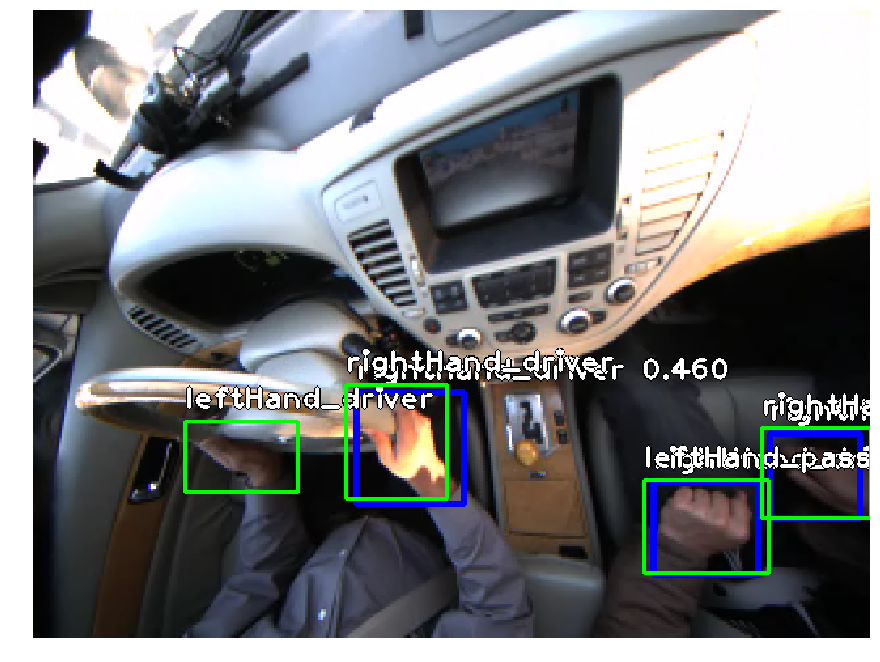

In [4]:
# load image
image = val_generator.load_image(index)

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[0, :, :4] /= scale

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.25:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(val_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [5]:
type(detections)

numpy.ndarray

In [6]:
detections.shape

(1, 300, 8)

In [7]:
print(detections)

[[[  4.74610199e+02   3.60155945e+02   5.54025940e+02 ...,   5.26105821e-01
     4.25408244e-01   3.71563077e-01]
  [  2.47950150e+02   2.92965607e+02   3.29717712e+02 ...,   4.60398346e-01
     3.44533741e-01   2.95156449e-01]
  [  5.63238342e+02   3.23197723e+02   6.32990601e+02 ...,   3.38906586e-01
     2.61814922e-01   2.47641429e-01]
  ..., 
  [  1.23456345e+02   1.75240387e+02   4.52178070e+02 ...,   2.21084021e-02
     1.86340846e-02   1.82107091e-02]
  [  4.96759277e+02   3.90105667e+01   6.01602051e+02 ...,   2.20771972e-02
     1.81800984e-02   1.73757616e-02]
  [  5.40165527e+02   3.54471497e+02   5.68385742e+02 ...,   2.20726375e-02
     1.78707708e-02   2.04898678e-02]]]


In [8]:
print(scores)

[ 0.52610582  0.46039835  0.33890659  0.22576949  0.22066516  0.17028967
  0.15974413  0.15651135  0.14710326  0.1404316   0.12170108  0.11883451
  0.11608011  0.1075842   0.10469443  0.10301436  0.09966169  0.09641467
  0.09541027  0.08814782  0.08795905  0.08308096  0.08262548  0.08124112
  0.0798315   0.07959668  0.07853398  0.07818303  0.07777386  0.07559179
  0.07211456  0.07136522  0.07075744  0.07005393  0.06806948  0.0631614
  0.06205345  0.0603122   0.05996262  0.05994776  0.05639781  0.05523485
  0.0545744   0.05430496  0.05365412  0.05327798  0.05284874  0.05246779
  0.05088183  0.05024157  0.04965532  0.04926491  0.04891695  0.04843029
  0.04813235  0.0469853   0.04655104  0.04654002  0.04612901  0.04602475
  0.04563898  0.04508318  0.04508131  0.04457391  0.04437421  0.04371645
  0.04308389  0.04285684  0.0421267   0.04191352  0.04172645  0.04085605
  0.04072984  0.04071541  0.04068804  0.04045704  0.04030056  0.04027728
  0.03953909  0.03938514  0.03914022  0.03862442  0.

In [9]:
def extract_box(path):
    """extract_box
    Extract annotation box positions for each labels from VIVA hand dataset.
    output is a list of tuples.

    :param path: text file path
    """

    with open(path) as temp:
        output = []

        for i, line in enumerate(temp):

            if i != 0 and line:
                label, x_1, y_1, x_off, y_off, *_ = line.split()
                pt_1 = (int(x_1), int(y_1))
                pt_2 = (pt_1[0] + int(x_off), (pt_1[1] + int(y_off)))
                output.append((label, pt_1, pt_2))

    return output


In [10]:
import csv
import os
import glob

annotations_dir = '../data/detectiondata/test/posGt/'

annotations_paths = sorted(glob.glob(annotations_dir + '*'))

with open('./score.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for annotations_path in annotations_paths:
        annotations = extract_box(annotations_path)
        filename = os.path.splitext(os.path.split(annotations_path)[1])[0]
        for annotation in annotations:
            # 10L_0015700_Q_1_4_5 463.867645 15.248428 64.009430 39.314926 0.012179 -1 -1 -1
            row = '{} {} {} {} {} 1.0 -1 -1 -1'.format(filename, annotation[1][0], annotation[1][1],
                             annotation[2][0], annotation[2][1])
            writer.writerow([row])

In [11]:
import PIL.Image

def process_image(image):
    # copy to draw on
    draw = image.copy()

    # preprocess image for network
    image = val_generator.preprocess_image(image)
    image, scale = val_generator.resize_image(image)
    annotations = val_generator.load_annotations(index)

    # process image
    start = time.time()
    _, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # compute predicted labels and scores
    predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
    scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

    # correct for image scale
    detections[0, :, :4] /= scale

    # visualize detections
    for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
        if score < 0.1:
            continue
        b = detections[0, idx, :4].astype(int)
        cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
        caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
        cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)

    return draw

In [12]:
import imageio
imageio.plugins.ffmpeg.download()

from moviepy.editor import VideoFileClip

def process_video (input_path, output_path):
    clip = VideoFileClip (input_path)
    result = clip.fl_image(process_image)
    %time result.write_videofile (output_path, audio=False)

process_video ('test_realtime.mp4', 'test_realtime_result.mp4')

processing time:  6.62768030166626
[MoviePy] >>>> Building video test_realtime_result.mp4
[MoviePy] Writing video test_realtime_result.mp4


  0%|          | 0/55 [00:00<?, ?it/s]

KeyboardInterrupt: 